In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import glob
import cv2
import numpy as np
import time
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split


C:\Users\carola\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Writeup 

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [3]:
# Reading all the data from souce
car_dataset_png = glob.glob('./vehicles/*/*.png')
non_car_dataset_png = glob.glob('./non-vehicles/*/*.png')

#### Image list in dataset 
since the dataset that given has an near about same number of images. So we need not require any data augmentation for this case.

In [4]:
#Total number of images present
print('Total number of car images',len(car_dataset_png))
print('Total number of non-car images',len(non_car_dataset_png))

Total number of car images 8792
Total number of non-car images 8968


# PipeLine 1 :- Extract feature

As a part of feature extraction, following methods are applied to make the pipeline detect the car object.

I have used the color space of 'YCrCb' as a color space for this pipeline.

In [5]:
################################################################################################################################
'''Function to convert the image supplied to the given color_space parameter value. 
   Function parameter - 
   1. image - Image which is to be converted into the specified image format
   2. color_space - Format in which we want to have [List of image conversion possible is 'HSV','LUV','HLS','YUV','YCrCb']
   
   Return values :- converted image in the specified format
   '''
################################################################################################################################
def color_conversion(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            color_converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            color_converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            color_converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            color_converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            color_converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: color_converted_image = np.copy(image)

    return color_converted_image

In [6]:
# Define a function to compute color features which will spatial binning on an image, so that we are able to
# retain information to help in finding vehicles.
def spatial_binning(img, size=(32, 32)):
    # Using cv2.resize function to scale down the resolution of an image
    features = cv2.resize(img, size)
    # converting the featues into a one dimensional feature vector
    features=features.ravel() 
    # Return the feature vector
    return features

In [7]:
# Define a function to compute color histogram features
def color_histogram(image, nbins=16, bins_range=(0, 256)):
    #Getting the histogram for all the channels seperately
    ch1 = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ch2 = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    ch3 = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Since we need only one histogram, we are concatenating all the histogram into a single feature vector
    features = np.concatenate((ch1[0], ch2[0], ch3[0]))
    # Return the feature vector
    return features

In [8]:
# function that would return HOG features and visualization(if needed)
def extract_hog_features(image, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    if vis :
        features, hog_image = hog(image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(image, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [9]:
def extract_feature(image_list, color_space='RGB', spatial_size=(16, 16),
                        histogram_bins=16, orientation=9,
                        pixels_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feature=True, histogram_feature=True, hog_feature=True,hog_vis=False):
    #This variable would hold the list of featuer vector 
    features_vector = []
    #Reading all the images from the image_list variable
    for image_path in image_list:
        image_features = []
        # Reading image using mpimg, thus the default color format would be RGB
        image = mpimg.imread(image_path)
        feature_image = color_conversion(image, color_space)
        if spatial_feature:
            # Apply spatial binning of Colors
            spatial_features = spatial_binning(feature_image, size=spatial_size)
            image_features.append(spatial_features)
        if histogram_feature:
            # Applying histograms of pixel intensity (color histograms) as features.
            histogram_features = color_histogram(feature_image, nbins=histogram_bins)
            image_features.append(histogram_features)
        if hog_feature:
            #Applying the HOG feature extraction
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(extract_hog_features(feature_image[:,:,channel],
                                        orientation, pixels_per_cell, cell_per_block,
                                        vis=hog_vis, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = extract_hog_features(feature_image[:,:,hog_channel], orientation,
                            pixels_per_cell, cell_per_block, vis=hog_vis, feature_vec=True)
            # Append the new feature vector to the features list
            image_features.append(hog_features)
        features_vector.append(np.concatenate(image_features))
        
    return features_vector

In [10]:
def data_split(car_features,non_car_features,scaled_X,Y,percentage=0.2):
    car_split    = len(car_features) * 0.2
    notcar_split = len(non_car_features) * 0.2
    X_test = np.vstack((scaled_X[:int(car_split)],
    scaled_X[len(car_features):(len(car_features) + int(notcar_split))]))
    y_test = np.hstack((Y[:int(car_split)],
            Y[len(car_features):(len(car_features) + int(notcar_split))]))
    X_train = np.vstack((scaled_X[int(car_split):len(car_features)],
            scaled_X[(len(car_features) + int(notcar_split)):]))
    y_train = np.hstack((Y[int(car_split):len(car_features)],
            Y[(len(car_features) + int(notcar_split)):]))
    return X_train,y_train,X_test,y_test
       

In [11]:
#Train the SVM model
def svm_model_train(X_train,y_train):
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return svc

In [12]:
def save_data(svc,X_scaler):
    print('Saving data to pickle file...')
    try:
        with open('processed_svc.p', 'wb') as pfile:
            pickle.dump(
                {   'svc':svc,
                    'X_scaler':X_scaler
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', ':', e)
        raise

    print('Data cached in pickle file.')

def load_model():
    svc = pickle.load(open('processed_svc.p',"rb"))
    return svc

In [ ]:
#Parameters to be passed
color_space='YCrCb'
spatial_size=(16, 16)
histogram_bins=16
orientation=9
pixels_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feature=True
histogram_feature=True
hog_feature=True
hog_vis=False

car_features = extract_feature(car_dataset_png,color_space=color_space
                                ,spatial_size=spatial_size
                                ,histogram_bins=histogram_bins
                                ,orientation=orientation
                                ,pixels_per_cell=pixels_per_cell
                                ,cell_per_block=cell_per_block
                                ,hog_channel=hog_channel
                                ,spatial_feature=spatial_feature
                                ,histogram_feature=histogram_feature
                                ,hog_feature=hog_feature
                                ,hog_vis=hog_vis)

non_car_features = extract_feature(non_car_dataset_png,color_space=color_space
                                ,spatial_size=spatial_size
                                ,histogram_bins=histogram_bins
                                ,orientation=orientation
                                ,pixels_per_cell=pixels_per_cell
                                ,cell_per_block=cell_per_block
                                ,hog_channel=hog_channel
                                ,spatial_feature=spatial_feature
                                ,histogram_feature=histogram_feature
                                ,hog_feature=hog_feature
                                ,hog_vis=hog_vis)

X = np.vstack((car_features, non_car_features)).astype(np.float64)
#normalizing the features that was extracted
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
#Getting labels, For Car images we are setting label to 1 (an array) and for not a car object we are setting it to 0
Y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

X_train,y_train,X_test,y_test=data_split(car_features,non_car_features,scaled_X,Y,0.2)
print('Using:',orientation,'orientations',pixels_per_cell,
               'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_train.shape, 'X_train.shape')
print(y_train.shape, 'y_train.shape')
print(X_test.shape, 'X_test')
print(y_test.shape, 'y_test shape')
print(scaled_X.shape, 'scaled_X shape')
print(Y.shape, 'y  shape')
t=time.time()
svc=svm_model_train(X_train,y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


In [ ]:
import pickle
save_data(svc,X_scaler)

In [13]:
import pickle
with open('processed_svc.p', mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']

In [14]:
def find_cars(image,svc , X_scaler,color_space,spatial_size= (16, 16),histogram_bins= 16,orient = 9,pixels_per_cell = 8,
              cell_per_block = 2,hog_channel= 'ALL',spatial_feature= True,hist_feature= True,hog_feature= True,cells_per_step = 1,
              scales = [1, 1.5, 2, 2.5, 4],window = 64,y_start_stops= [[380, 460], [380, 560], [380, 620], [380, 680], [350, 700]]):
    draw_img = np.copy(image)
    img = image.astype(np.float32)/255
    hot_windows = []
    for y_start_stop,scales in zip (y_start_stops,scales):
        images_to_search=img[y_start_stop[0]:y_start_stop[1],:,:]
        image_color_transformed=color_conversion(images_to_search,color_space)
        if scales != 1:
            imshape = image_color_transformed.shape
            image_color_transformed = cv2.resize(image_color_transformed,
                                             (np.int(imshape[1]/scales), np.int(imshape[0]/scales)))
        #Get different color channels and store it in different variable
        color_channel1=image_color_transformed[:,:,0]
        color_channel2=image_color_transformed[:,:,1]
        color_channel3=image_color_transformed[:,:,2]
        # to get the number of features per block 
        num_x_blocks = (color_channel1.shape[1] // pixels_per_cell) - cell_per_block + 1
        num_y_blocks = (color_channel1.shape[0] // pixels_per_cell) - cell_per_block + 1 
        num_features_per_block = orient*cell_per_block**2
        # Getting the hog fe
        hog1 = extract_hog_features(color_channel1, orient,
                    pixels_per_cell, cell_per_block, feature_vec=False)
        hog2 = extract_hog_features(color_channel2, orient,
                    pixels_per_cell, cell_per_block, feature_vec=False)
        hog3 = extract_hog_features(color_channel3, orient,
                    pixels_per_cell, cell_per_block, feature_vec=False)

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        nblocks_per_window = (window // pixels_per_cell)-1
        #print('number of blocks per window is :- ',nblocks_per_window)
        nxsteps = (num_x_blocks - nblocks_per_window) // cells_per_step
        nysteps = (num_y_blocks - nblocks_per_window) // cells_per_step
        i=0
        #print('number of x steps  :- ',nxsteps, '  and number of y steps :- ' , nysteps)
        for xb in range(nxsteps+1):
            for yb in range(nysteps+1):
                i += 1
                if xb == (nxsteps + 1):
                    xpos = color_channel1.shape[1] - nblocks_per_window
                else:
                    xpos = xb*cells_per_step
                if yb == (nysteps + 1):
                    ypos = ch1.shape[0] - nblocks_per_window
                else:
                    ypos = yb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                if hog_channel == 'ALL':
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                elif hog_channel == '0':
                    hog_features = hog_feat1
                elif hog_channel == '1':
                    hog_features = hog_feat2
                elif hog_channel == '2':
                    hog_features = hog_feat3
                xleft = xpos*pixels_per_cell
                ytop  = ypos*pixels_per_cell
                subimg = cv2.resize(image_color_transformed[ytop:ytop+window, xleft:xleft+window], (64,64))
                # Get color features
                spatial_features = spatial_binning(subimg, size=spatial_size)
                hist_features    = color_histogram(subimg, nbins=histogram_bins)    
                image_features = []
                if spatial_feature:
                    image_features.append(spatial_features)
                if hist_feature:
                    image_features.append(hist_features)
                if hog_feature:
                    image_features.append(hog_features)

                image_features = np.concatenate(image_features).reshape(1, -1)
                # Scale features and make a prediction
                test_features   = X_scaler.transform(image_features)
                test_prediction = svc.predict(test_features)

                xbox_left = np.int(xleft*scales)
                ytop_draw = np.int(ytop*scales)
                win_draw = np.int(window*scales)

                if test_prediction == 1:
                    hot_windows.append(((xbox_left, ytop_draw+y_start_stop[0]),
                        (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])))
    return hot_windows

    
    

In [15]:
def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    # take a copy of the image
    imcopy = np.copy(image)
    # Iterate over the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

C:\Users\carola\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


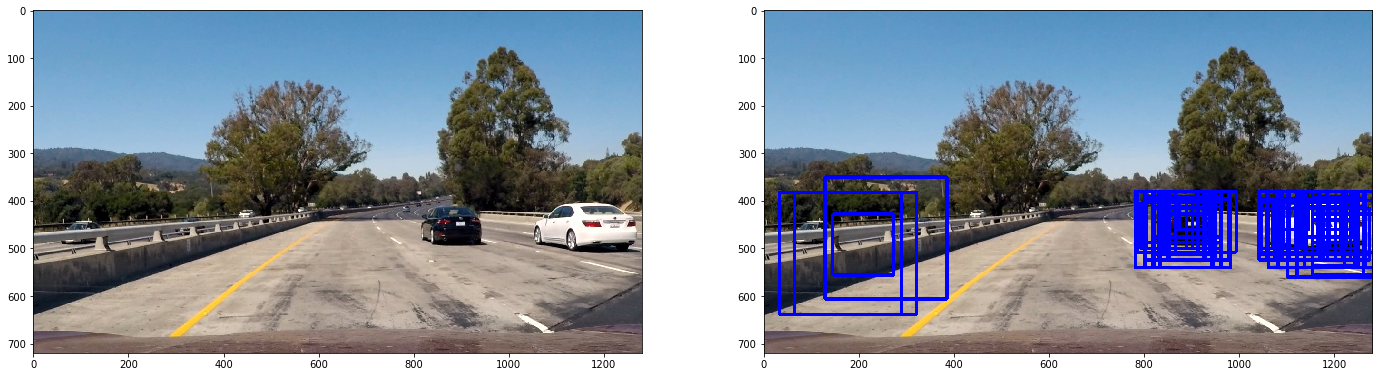

In [16]:
svc            = svc
X_scaler       = X_scaler
color_space    = 'YCrCb'
spatial_size   = (16, 16)
histogram_bins = 16
orient         = 9
pixels_per_cell = 8
cell_per_block = 2
hog_channel       = 'ALL'
spatial_feature   = True
hist_feature      = True
hog_feature       = True
cells_per_step = 1
scales         = [1, 1.5, 2, 2.5, 4]
window         = 64
y_start_stops  = [[380, 460], [380, 560], [380, 620], [380, 680], [350, 700]]

image = mpimg.imread('test_images/test1.jpg')
hot_windows=find_cars(image,svc=svc , 
                X_scaler=X_scaler,
                color_space=color_space,
                spatial_size= spatial_size,
                histogram_bins= histogram_bins,
                orient = orient,
                pixels_per_cell = pixels_per_cell,
                cell_per_block = cell_per_block,
                hog_channel= hog_channel,
                spatial_feature= spatial_feature,
                hist_feature= hist_feature,
                hog_feature= hog_feature,
                cells_per_step= cells_per_step,
                scales=scales,
                window=window,
                y_start_stops= y_start_stops)
draw_image  = np.copy(image)
draw_image  = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax2.imshow(draw_image)
ax1.imshow(image)


# Heat Maps

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [18]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
heat = apply_threshold(heat,2) 



In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def add_heat(heatmap, bbox_list):
    """ Hotter areas correspond to multiple boxes detected in that space.
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [25]:
class ImageProcessor():
    def __init__(self):
        self.heat_list = []
        self.heat_frames=15
    def add_heat(self, heat):
        self.heat_list.append(heat)
    def call(self, image,hot_windows,display=False):
        #Copying the image to which the heat maps would be drawn
        draw_image = np.copy(image)
        #Creating an heatmap with all zeros
        heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)
        #Increase the intensity where the maxiumum number of window is found
        heat=add_heat(heatmap,hot_windows)
        #Adding all the hot window points to the heat_list attribute
        self.add_heat(heat)
        #Removing the oldest element from the heat_list when the length of heat_list increase heat_frames
        if len(self.heat_list) > self.heat_frames:
            self.heat_list = self.heat_list[1:self.heat_frames+1]
        # Make into array so np.mean will calculate for each value in the image
        recent_heat_array = np.array(self.heat_list)
        # Take the average heat
        avg_heat = np.sum(np.array(recent_heat_array), axis=0)
    
        draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

        avg_heat = apply_threshold(avg_heat,4) 
        # Visualize the heatmap when displaying    
        heatmap = np.clip(avg_heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)

        # draw the bounding box on the image 
        draw_image = np.copy(image)
        draw_image = draw_labeled_bboxes(draw_image, labels)
                
        if display:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(draw_image)
            ax2.imshow(heatmap, cmap='hot')
            ax2.set_title('heatmap', fontsize=40)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
            
        return draw_image

test image shape is: (744, 1253, 4)
[((864, 400), (928, 464)), ((1008, 416), (1072, 480)), ((1020, 400), (1116, 496)), ((1128, 432), (1224, 528)), ((1140, 432), (1236, 528)), ((1152, 432), (1248, 528)), ((1008, 400), (1136, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((1120, 432), (1248, 560))]


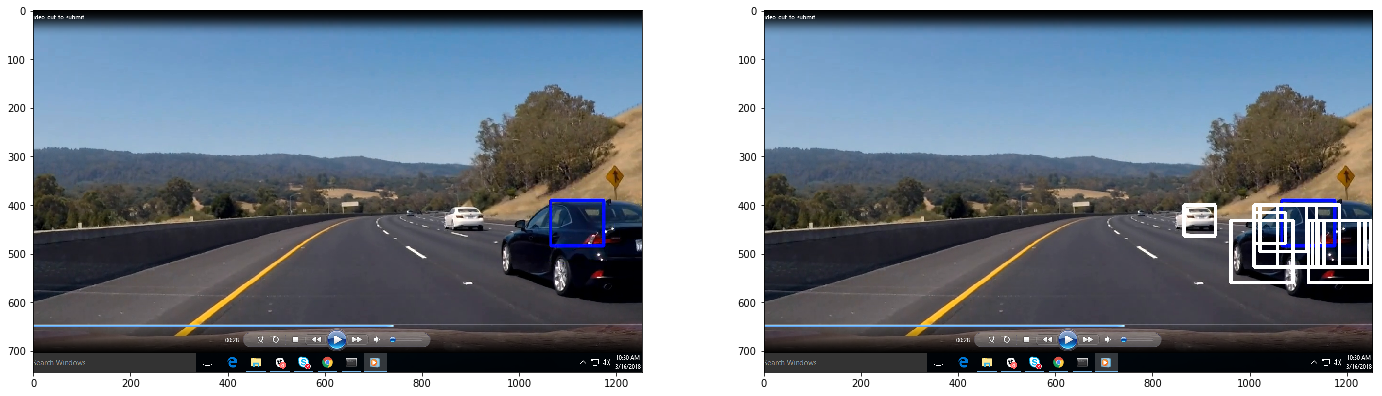

In [26]:
impro = ImageProcessor()
scales         = [1.5,1,1, 1.5,1.5,2,2, 3.5, 3.5]
window         = 64
y_start_stops  = [[388,450],[400,464],[416,480],[400,496],[432,528],[400,528],[432,560],[400,596],[464,660]]
images = glob.glob("./Capture.png")
#plt.imshow(images)        
for each in images:
    time1 = time.time()
    image = mpimg.imread(each)
    hot_windows=find_cars(image,svc=svc , 
                X_scaler=X_scaler,
                color_space=color_space,
                spatial_size= spatial_size,
                histogram_bins= histogram_bins,
                orient = orient,
                pixels_per_cell = pixels_per_cell,
                cell_per_block = cell_per_block,
                hog_channel= hog_channel,
                spatial_feature= spatial_feature,
                hist_feature= hist_feature,
                hog_feature= hog_feature,
                cells_per_step= cells_per_step,
                scales=scales,
                window=window,
                y_start_stops= y_start_stops)
    print("test image shape is:", image.shape)
    print(hot_windows)
    draw_image=np.copy(image)
    draw_image  = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax2.imshow(draw_image)
    ax1.imshow(image)
    #draw_image = impro.call(image,hot_windows,True)        

In [27]:
impro = ImageProcessor()
def final_processing(img):
    hot_windows=find_cars(img,svc=svc , 
                X_scaler=X_scaler,
                color_space=color_space,
                spatial_size= spatial_size,
                histogram_bins= histogram_bins,
                orient = orient,
                pixels_per_cell = pixels_per_cell,
                cell_per_block = cell_per_block,
                hog_channel= hog_channel,
                spatial_feature= spatial_feature,
                hist_feature= hist_feature,
                hog_feature= hog_feature,
                cells_per_step= cells_per_step,
                scales=scales,
                window=window,
                y_start_stops= y_start_stops)
    print 
    draw_image = impro.call(img,hot_windows,False)  
    return draw_image

In [ ]:
from moviepy.editor import VideoFileClip
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(5,12)
write_clip = clip1.fl_image(final_processing)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


 23%|██████████████████                                                             | 288/1261 [04:30<16:25,  1.01s/it]

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(write_output))